In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
from collections import Counter
from sklearn.preprocessing import LabelEncoder
from wordcloud import WordCloud
from sklearn import model_selection, linear_model, naive_bayes
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn import ensemble
import xgboost
from sklearn import svm
from sklearn.svm import SVC
from sklearn.metrics import classification_report
import warnings
warnings.filterwarnings('ignore')
import sklearn.metrics as mt
from sklearn.model_selection import GridSearchCV

# Classification of Disaster Tweets with Machine Learning

In [3]:
train_data = pd.read_csv("./datasets/train.csv")
test_data = pd.read_csv("./datasets/test.csv")
sample_submission = pd.read_csv("./datasets/sample_submission.csv")
df_train = train_data.copy()
df_test = test_data.copy()

In [4]:
df_train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [5]:
df_test.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [6]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


In [7]:
df_train.describe()

,id,target
count,7613.000000,7613.00000
mean,5441.934848,0.42966
std,3137.116090,0.49506
min,1.000000,0.00000
25%,2734.000000,0.00000
50%,5408.000000,0.00000
75%,8146.000000,1.00000
max,10873.000000,1.00000


In [8]:
print(df_train.duplicated(['text', 'target']).sum())
print(df_train.duplicated(['text']).sum())

92
110


In [9]:
df_train = df_train.drop_duplicates(["text", "target"])
df_train = df_train.drop(index=df_train[df_train.duplicated('text', keep=False)].index)

In [10]:
len(df_train['keyword'].unique())

222

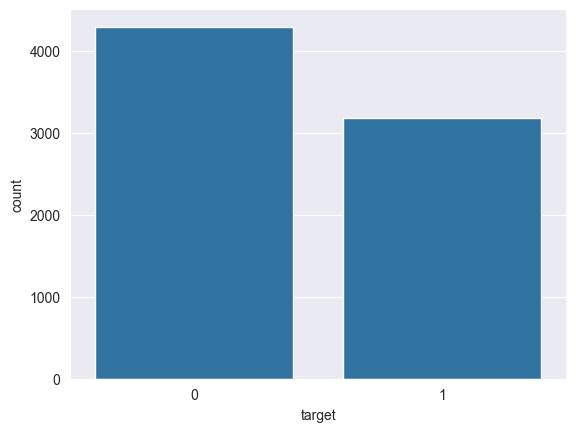

In [11]:
sns.countplot(x="target", data=df_train);

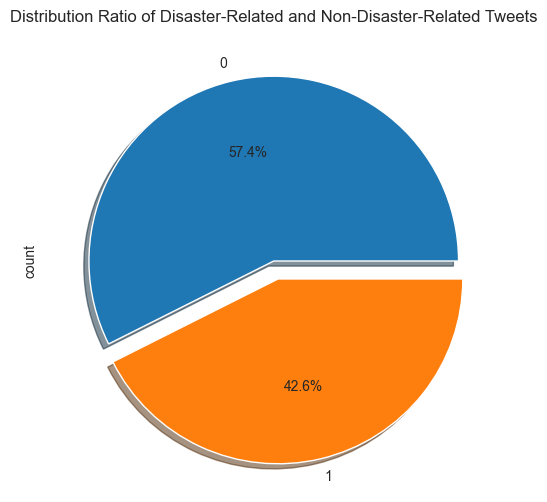

In [14]:
df_train["target"].value_counts().plot.pie(autopct='%1.1f%%', explode = [0, 0.1], figsize = (6, 6),shadow = True)
plt.title("Distribution Ratio of Disaster-Related and Non-Disaster-Related Tweets");

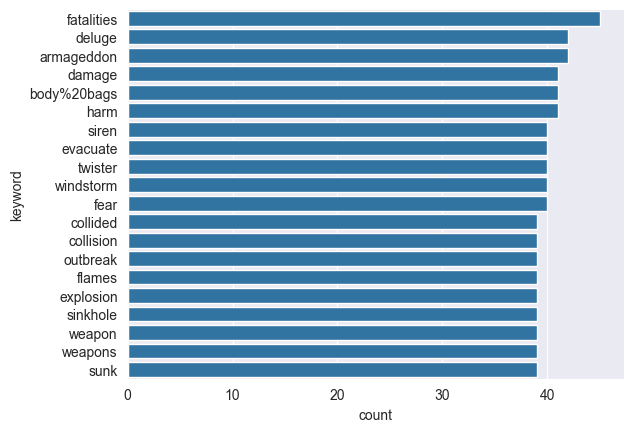

In [15]:
sns.barplot(y=df_train['keyword'].value_counts()[:20].index,x=df_train['keyword'].value_counts()[:20], orient='h');

In [16]:
df_train['keyword'].value_counts()[:20]

keyword
fatalities     45
deluge         42
armageddon     42
damage         41
body%20bags    41
harm           41
siren          40
evacuate       40
twister        40
windstorm      40
fear           40
collided       39
collision      39
outbreak       39
flames         39
explosion      39
sinkhole       39
weapon         39
weapons        39
sunk           39
Name: count, dtype: int64

In [17]:
encoder = LabelEncoder()
df_train['keyword'] = encoder.fit_transform(df_train['keyword'])
df_test['keyword'] = encoder.transform(df_test['keyword'])

In [18]:
df_train.head()

,id,keyword,location,text,target
0,1,221,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,221,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,221,NaN,All residents asked to 'shelter in place' are ...,1
3,6,221,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,221,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [19]:
df_train['location'].replace({'United States':'USA',
                           'New York':'USA',
                            "London":'UK',
                            "Los Angeles, CA":'USA',
                            "Washington, D.C.":'USA',
                            "California":'USA',
                             "Chicago, IL":'USA',
                             "Chicago":'USA',
                            "New York, NY":'USA',
                            "California, USA":'USA',
                            "FLorida":'USA',
                            "Nigeria":'Africa',
                            "Kenya":'Africa',
                            "Everywhere":'Worldwide',
                            "San Francisco":'USA',
                            "Florida":'USA',
                            "United Kingdom":'UK',
                            "Los Angeles":'USA',
                            "Toronto":'Canada',
                            "San Francisco, CA":'USA',
                            "NYC":'USA',
                            "Seattle":'USA',
                            "Earth":'Worldwide',
                            "Ireland":'UK',
                            "London, England":'UK',
                            "New York City":'USA',
                            "Texas":'USA',
                            "London, UK":'UK',
                            "Atlanta, GA":'USA',
                            "Mumbai":"India"},inplace=True)

<Axes: xlabel='count', ylabel='location'>

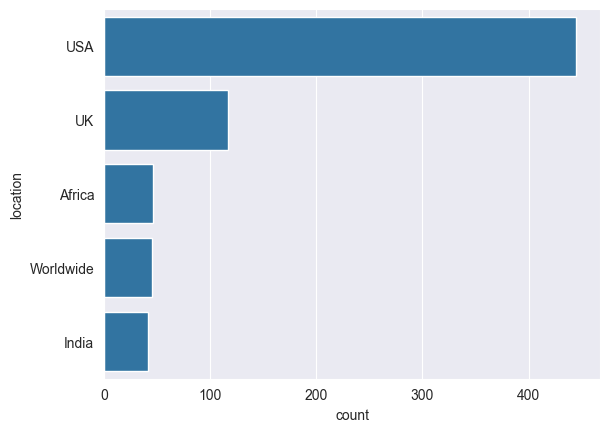

In [20]:
sns.barplot(y=df_train['location'].value_counts()[:5].index,x=df_train['location'].value_counts()[:5], orient='h')

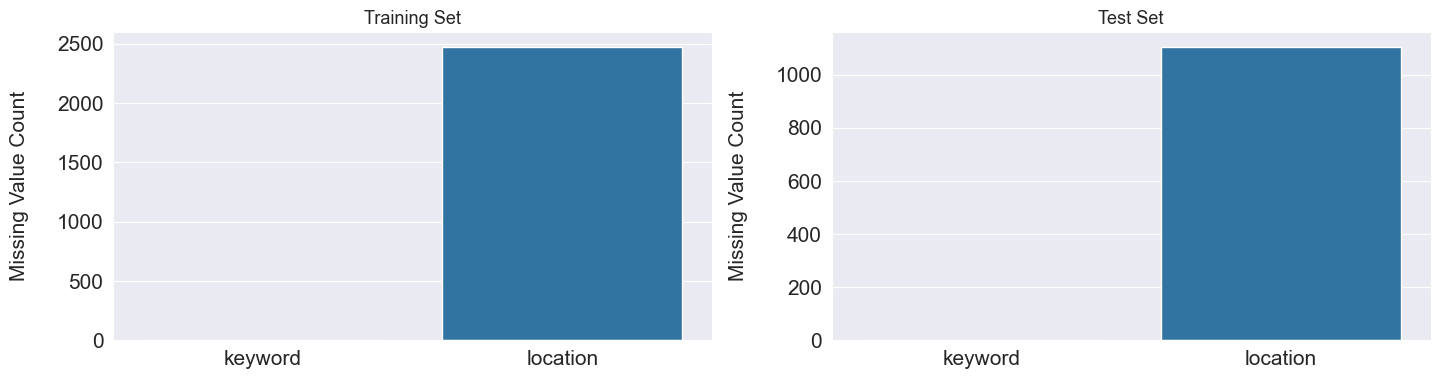

In [21]:
missing_cols = ['keyword', 'location']

# create bar plots for each set
fig, axes = plt.subplots(ncols=2, figsize=(17, 4), dpi=100)
for i, df in enumerate([df_train, df_test]):
    sns.barplot(x=missing_cols, y=df[missing_cols].isnull().sum().values, ax=axes[i])
    axes[i].set_ylabel('Missing Value Count', size=15, labelpad=20)
    axes[i].tick_params(axis='x', labelsize=15)
    axes[i].tick_params(axis='y', labelsize=15)
    axes[i].set_title(['Training Set', 'Test Set'][i], fontsize=13)

# impute missing values with "no_{col}"
for df in [df_train, df_test]:
    df[missing_cols] = df[missing_cols].fillna(f'no_{{col}}')

plt.show()

In [22]:
df_train["keyword"].fillna("None", inplace=True)
df_test["keyword"].fillna("None", inplace=True)

df_train["location"].fillna("None", inplace=True)
df_test["location"].fillna("None", inplace=True)

In [23]:
df = pd.concat([df_train, df_test], ignore_index=True)

In [24]:
df

,id,keyword,location,text,target
0,1,221,no_{col},Our Deeds are the Reason of this #earthquake M...,1.0
1,4,221,no_{col},Forest fire near La Ronge Sask. Canada,1.0
2,5,221,no_{col},All residents asked to 'shelter in place' are ...,1.0
3,6,221,no_{col},"13,000 people receive #wildfires evacuation or...",1.0
4,7,221,no_{col},Just got sent this photo from Ruby #Alaska as ...,1.0
...,...,...,...,...,...
10743,10861,221,no_{col},EARTHQUAKE SAFETY LOS ANGELES ÛÒ SAFETY FASTE...,NaN
10744,10865,221,no_{col},Storm in RI worse than last hurricane. My city...,NaN
10745,10868,221,no_{col},Green Line derailment in Chicago http://t.co/U...,NaN
10746,10874,221,no_{col},MEG issues Hazardous Weather Outlook (HWO) htt...,NaN


In [25]:
df = df.drop(['id'], axis=1)

In [26]:
x_df = df.copy()

In [34]:
x_df["text"].str.len()

0         69
1         38
2        133
3         65
4         88
        ... 
10743     55
10744    139
10745     55
10746     65
10747     68
Name: text, Length: 10748, dtype: int64

In [35]:
x_df["letter_number"] = x_df["text"].str.len()
x_df.head()

,keyword,location,text,target,harf_sayisi,letter_number
0,221,no_{col},Our Deeds are the Reason of this #earthquake M...,1.0,69,69
1,221,no_{col},Forest fire near La Ronge Sask. Canada,1.0,38,38
2,221,no_{col},All residents asked to 'shelter in place' are ...,1.0,133,133
3,221,no_{col},"13,000 people receive #wildfires evacuation or...",1.0,65,65
4,221,no_{col},Just got sent this photo from Ruby #Alaska as ...,1.0,88,88


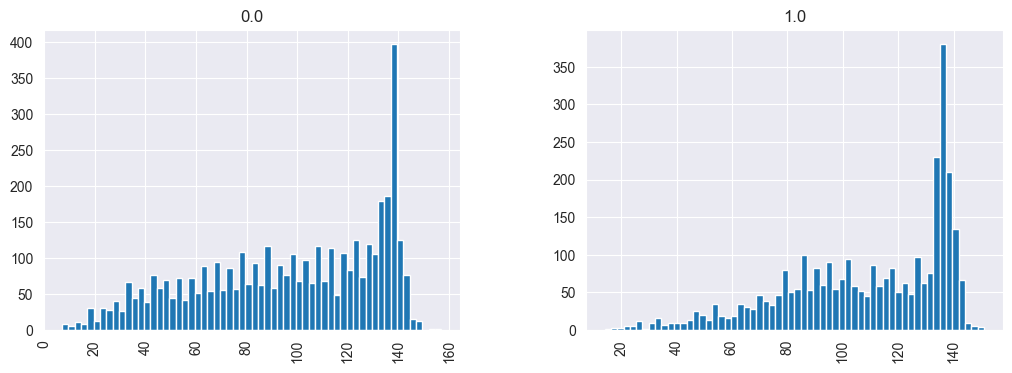

In [44]:
x_df.hist(column='letter_number',by='target',bins=60,figsize=(12,4));

In [47]:
x_df["Word Count"] = x_df["text"].apply(lambda x:len(str(x).split(" ")))
x_df.head()

,keyword,location,text,target,letter_number,Word Count
0,221,no_{col},Our Deeds are the Reason of this #earthquake M...,1.0,69,13
1,221,no_{col},Forest fire near La Ronge Sask. Canada,1.0,38,7
2,221,no_{col},All residents asked to 'shelter in place' are ...,1.0,133,22
3,221,no_{col},"13,000 people receive #wildfires evacuation or...",1.0,65,9
4,221,no_{col},Just got sent this photo from Ruby #Alaska as ...,1.0,88,17


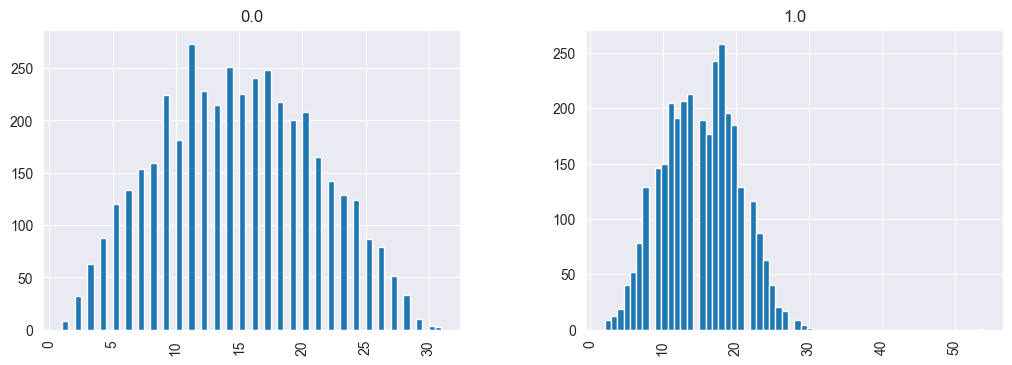

In [48]:
x_df.hist(column='Word Count',by='target',bins=60,figsize=(12,4));

In [49]:
x_df["number_of_issues"] = train_data["text"].apply(lambda x: len([x for x in x.split()
                                      if x.isdigit()]))

In [50]:
x_df.head()

,keyword,location,text,target,letter_number,Word Count,number_of_issues
0,221,no_{col},Our Deeds are the Reason of this #earthquake M...,1.0,69,13,0.0
1,221,no_{col},Forest fire near La Ronge Sask. Canada,1.0,38,7,0.0
2,221,no_{col},All residents asked to 'shelter in place' are ...,1.0,133,22,0.0
3,221,no_{col},"13,000 people receive #wildfires evacuation or...",1.0,65,9,0.0
4,221,no_{col},Just got sent this photo from Ruby #Alaska as ...,1.0,88,17,0.0


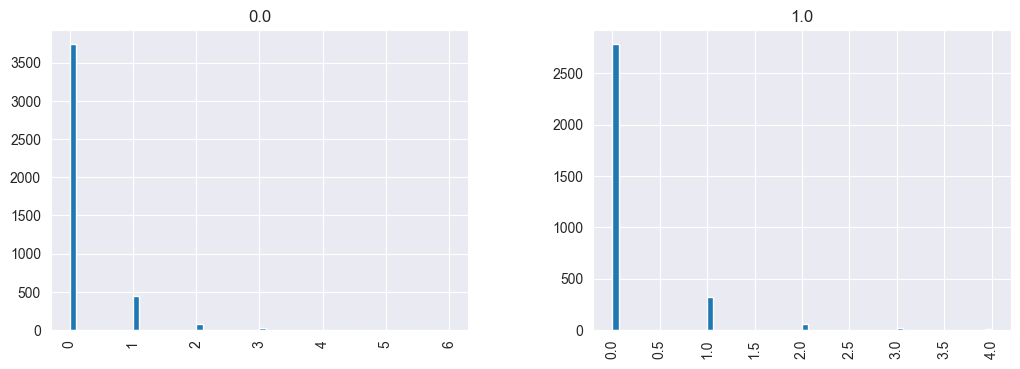

In [51]:
x_df.hist(column='number_of_issues',by='target',bins=60,figsize=(12,4));

In [52]:
x_df.describe().T

,count,mean,std,min,25%,50%,75%,max
keyword,10748.0,110.442966,64.495341,0.0,55.0,110.0,167.0,221.0
target,7485.0,0.425919,0.494515,0.0,0.0,0.0,1.0,1.0
letter_number,10748.0,101.380629,33.949214,5.0,78.0,108.0,134.0,157.0
Word Count,10748.0,14.923148,5.793816,1.0,11.0,15.0,19.0,54.0
number_of_issues,7613.0,0.161960,0.468294,0.0,0.0,0.0,0.0,6.0


<Figure size 1200x800 with 0 Axes>

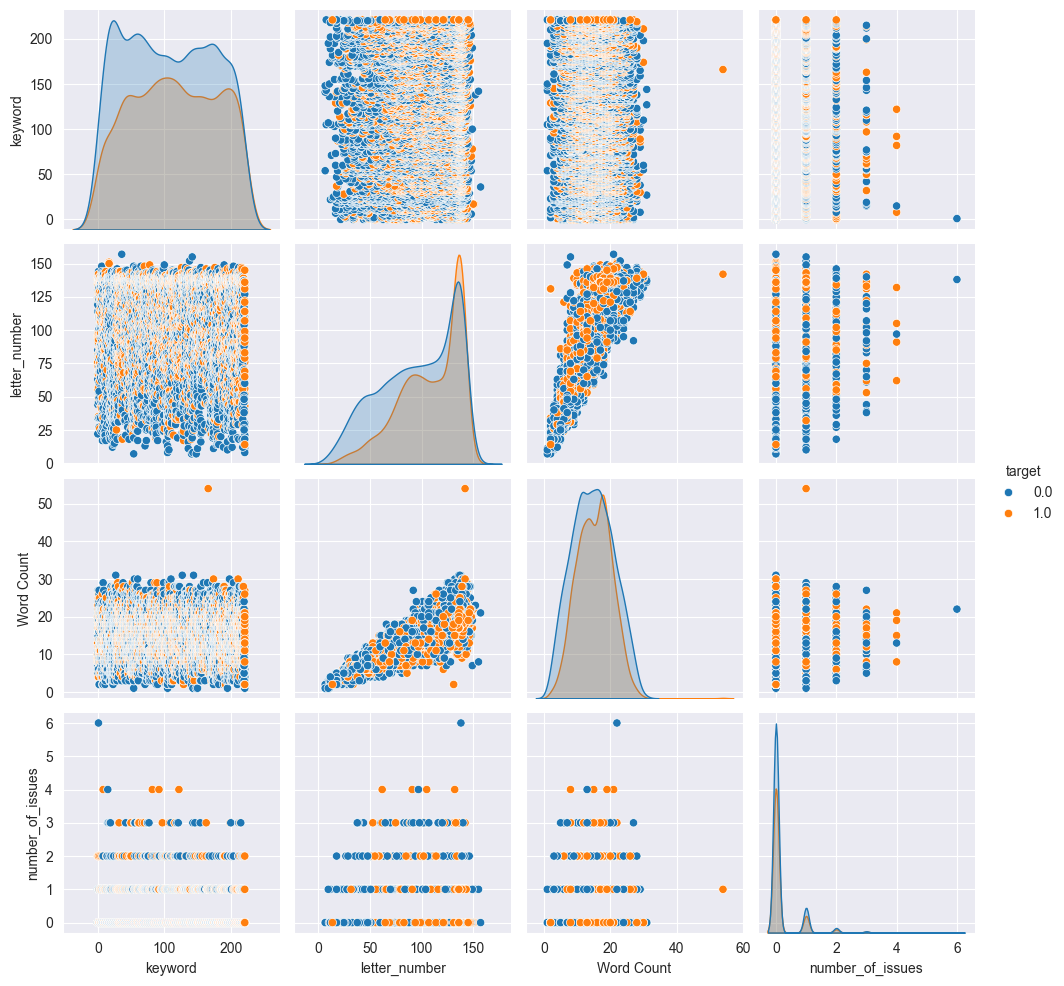

In [53]:
plt.figure(figsize=(12,8));
fg = sns.pairplot(data=x_df, hue="target")
plt.show(fg)

In [54]:
df = df.reset_index(drop=True)
df.head(50)

,keyword,location,text,target
0,221,no_{col},Our Deeds are the Reason of this #earthquake M...,1.0
1,221,no_{col},Forest fire near La Ronge Sask. Canada,1.0
2,221,no_{col},All residents asked to 'shelter in place' are ...,1.0
3,221,no_{col},"13,000 people receive #wildfires evacuation or...",1.0
4,221,no_{col},Just got sent this photo from Ruby #Alaska as ...,1.0
5,221,no_{col},#RockyFire Update => California Hwy. 20 closed...,1.0
6,221,no_{col},#flood #disaster Heavy rain causes flash flood...,1.0
7,221,no_{col},I'm on top of the hill and I can see a fire in...,1.0
8,221,no_{col},There's an emergency evacuation happening now ...,1.0
9,221,no_{col},I'm afraid that the tornado is coming to our a...,1.0


In [55]:
for i in range(len(df)):
    df["text"][i] = re.sub('(http|ftp|https)://([\w+?\.\w+])+([a-zA-Z0-9\~\!\@\#$\%\^\&\*_\-\=\+\\/\?\.\:\;\'\,]*)?', '', df["text"][i])
   
df.head()

,keyword,location,text,target
0,221,no_{col},Our Deeds are the Reason of this #earthquake M...,1.0
1,221,no_{col},Forest fire near La Ronge Sask. Canada,1.0
2,221,no_{col},All residents asked to 'shelter in place' are ...,1.0
3,221,no_{col},"13,000 people receive #wildfires evacuation or...",1.0
4,221,no_{col},Just got sent this photo from Ruby #Alaska as ...,1.0


In [56]:
for i in range(len(df)):
    df["text"][i] = re.sub('RT', '', df["text"][i])
    
df.head()

,keyword,location,text,target
0,221,no_{col},Our Deeds are the Reason of this #earthquake M...,1.0
1,221,no_{col},Forest fire near La Ronge Sask. Canada,1.0
2,221,no_{col},All residents asked to 'shelter in place' are ...,1.0
3,221,no_{col},"13,000 people receive #wildfires evacuation or...",1.0
4,221,no_{col},Just got sent this photo from Ruby #Alaska as ...,1.0


In [57]:
for i in range(len(df)):
    df["text"][i] = re.sub('[^a-zA-Z]', ' ', df["text"][i])
    
df.head(50)

,keyword,location,text,target
0,221,no_{col},Our Deeds are the Reason of this earthquake M...,1.0
1,221,no_{col},Forest fire near La Ronge Sask Canada,1.0
2,221,no_{col},All residents asked to shelter in place are ...,1.0
3,221,no_{col},people receive wildfires evacuation or...,1.0
4,221,no_{col},Just got sent this photo from Ruby Alaska as ...,1.0
5,221,no_{col},RockyFire Update California Hwy closed...,1.0
6,221,no_{col},flood disaster Heavy rain causes flash flood...,1.0
7,221,no_{col},I m on top of the hill and I can see a fire in...,1.0
8,221,no_{col},There s an emergency evacuation happening now ...,1.0
9,221,no_{col},I m afraid that the tornado is coming to our a...,1.0


In [58]:
df['text'] = df['text'].apply(lambda x: " ".join(x.lower() for x in x.split()))
df.head()

,keyword,location,text,target
0,221,no_{col},our deeds are the reason of this earthquake ma...,1.0
1,221,no_{col},forest fire near la ronge sask canada,1.0
2,221,no_{col},all residents asked to shelter in place are be...,1.0
3,221,no_{col},people receive wildfires evacuation orders in ...,1.0
4,221,no_{col},just got sent this photo from ruby alaska as s...,1.0


In [61]:
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
sw = stopwords.words('english')
sw

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 "she's",
 'her',
 'hers',
 'herself',
 'it',
 "it's",
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 "that'll",
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each

In [62]:
df['text'] = df['text'].apply(lambda x: " ".join(x for x in x.split() if x not in sw))

In [63]:
df.head(7000)

,keyword,location,text,target
0,221,no_{col},deeds reason earthquake may allah forgive us,1.0
1,221,no_{col},forest fire near la ronge sask canada,1.0
2,221,no_{col},residents asked shelter place notified officer...,1.0
3,221,no_{col},people receive wildfires evacuation orders cal...,1.0
4,221,no_{col},got sent photo ruby alaska smoke wildfires pou...,1.0
...,...,...,...,...
6995,207,UK,pov video captures violent landing amsterdam a...,1.0
6996,207,no_{col},storm blitzes traverse city disrupts managemen...,1.0
6997,207,Oshawa/Toronto,one violent belligerent storm enjoying watchin...,1.0
6998,207,"Very SW CA, USA....Draenor",iateyourfood yikes poor pup weird violent storm,1.0


In [64]:
least = pd.Series(" ".join(df["text"]).split()).value_counts().reset_index()
least.columns = ['words', 'tf']
least.head()

,words,tf
0,amp,508
1,like,488
2,fire,362
3,get,337
4,new,330


In [65]:
sil = least[least["tf"] < 50]
sil

,words,tf
369,wrecked,49
370,obliterated,49
371,report,49
372,obliterate,49
373,detonation,49
...,...,...
20111,jsyk,1
20112,thrillhho,1
20113,tyme,1
20114,smackdown,1


In [66]:
df['text'] = df['text'].apply(lambda x: " ".join(x for x in x.split() if x not in sil))

In [68]:
from textblob import Word
import nltk
nltk.download('wordnet')
nltk.download('omw-1.4')
df['text'] = df['text'].apply(lambda x: " ".join([Word(word).lemmatize() for word in x.split()])) 

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...


In [69]:
df[:20]

,keyword,location,text,target
0,221,no_{col},deed reason earthquake may allah forgive u,1.0
1,221,no_{col},forest fire near la ronge sask canada,1.0
2,221,no_{col},resident asked shelter place notified officer ...,1.0
3,221,no_{col},people receive wildfire evacuation order calif...,1.0
4,221,no_{col},got sent photo ruby alaska smoke wildfire pour...,1.0
5,221,no_{col},rockyfire update california hwy closed directi...,1.0
6,221,no_{col},flood disaster heavy rain cause flash flooding...,1.0
7,221,no_{col},top hill see fire wood,1.0
8,221,no_{col},emergency evacuation happening building across...,1.0
9,221,no_{col},afraid tornado coming area,1.0


In [70]:
tf1 = pd.Series(' '.join(df['text']).lower().split()).value_counts().reset_index()
tf1.columns = ['words', 'tf']

In [71]:
tf1.head()

,words,tf
0,fire,517
1,amp,508
2,like,491
3,get,382
4,u,373


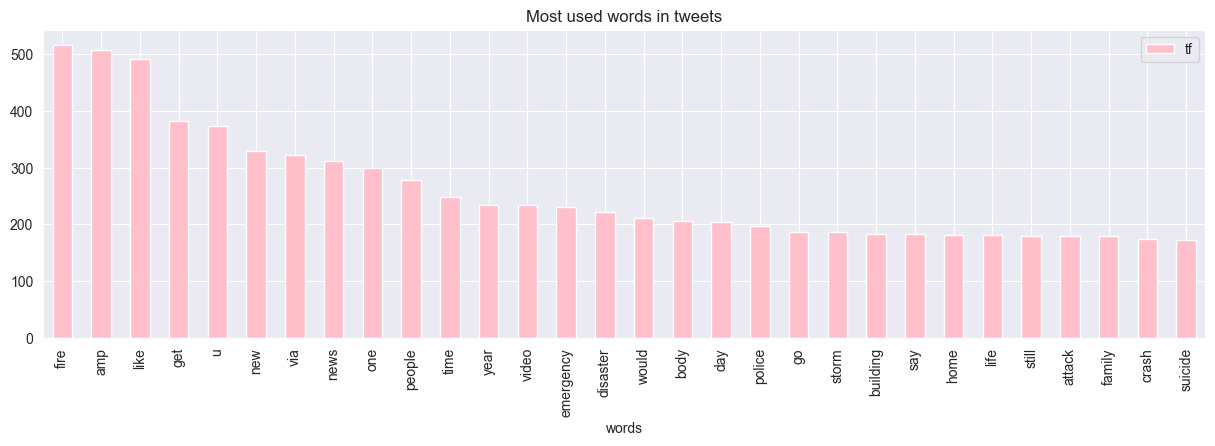

In [72]:
tf1[:30].plot.bar(x="words", y="tf", figsize=(15,4), color="pink");
plt.title('Most used words in tweets');

In [73]:
non_disaster_tweets_count = Counter(" ".join(df[df['target']==0]["text"]).split()).most_common(20)
non_disaster_tweets_count_df = pd.DataFrame(non_disaster_tweets_count, columns=["words", "freq"])
print("The 20 most used words in non-disaster tweets:")
non_disaster_tweets_count_df

The 20 most used words in non-disaster tweets:


,words,freq
0,like,254
1,amp,208
2,get,185
3,new,171
4,u,155
5,one,139
6,body,119
7,time,106
8,day,104
9,video,101


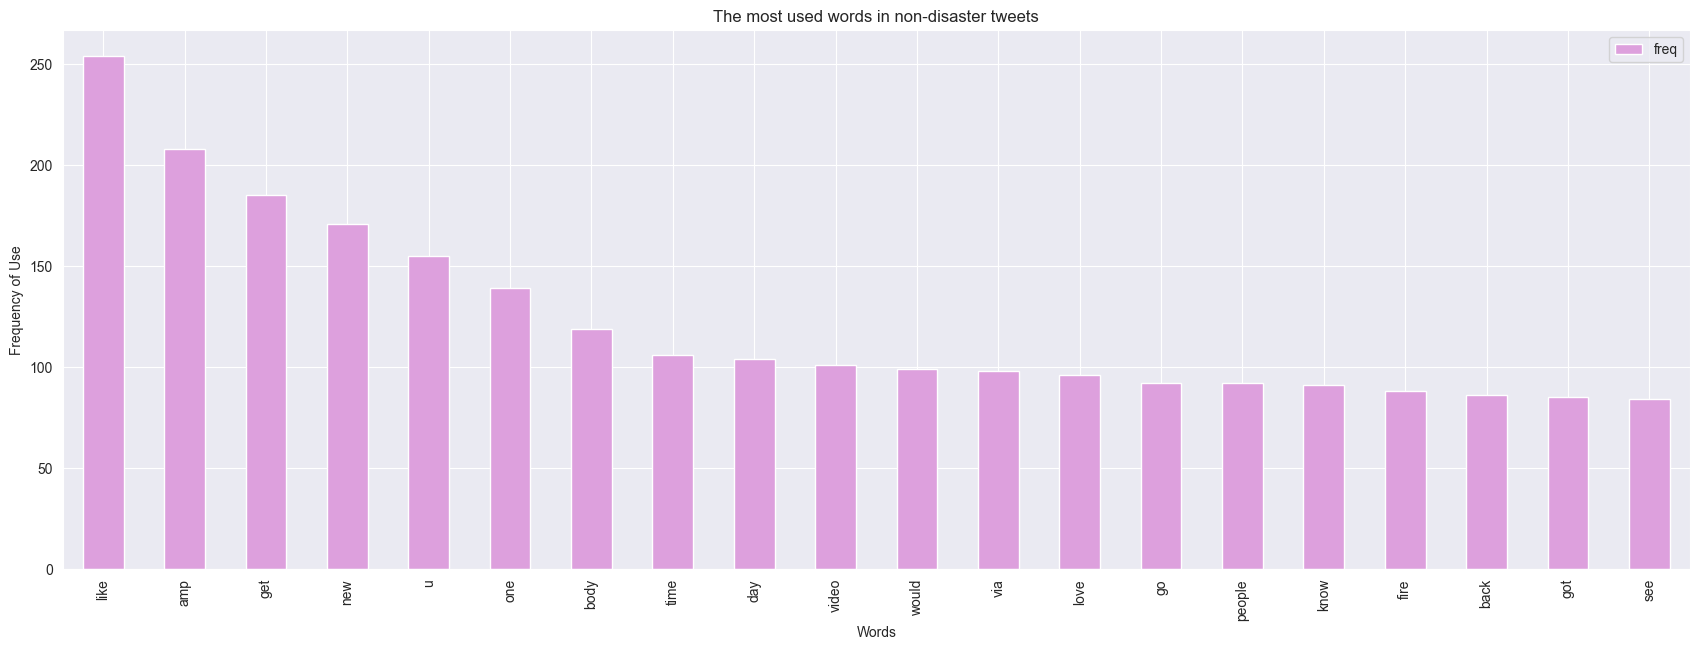

In [74]:
non_disaster_tweets_count_df.plot.bar(x="words", y="freq", figsize=(21,7), color="plum")
plt.title('The most used words in non-disaster tweets')
plt.xlabel('Words')
plt.ylabel('Frequency of Use');

In [75]:
disaster_tweets_count = Counter(" ".join(df[df['target']==1]["text"]).split()).most_common(20)
disaster_tweets_count_df = pd.DataFrame(disaster_tweets_count, columns=["words", "freq"])
print("The 20 most used words in disaster-related tweets:")
disaster_tweets_count_df

The 20 most used words in disaster-related tweets:


,words,freq
0,fire,262
1,news,149
2,amp,134
3,via,119
4,disaster,117
5,california,114
6,u,110
7,police,107
8,suicide,106
9,people,102


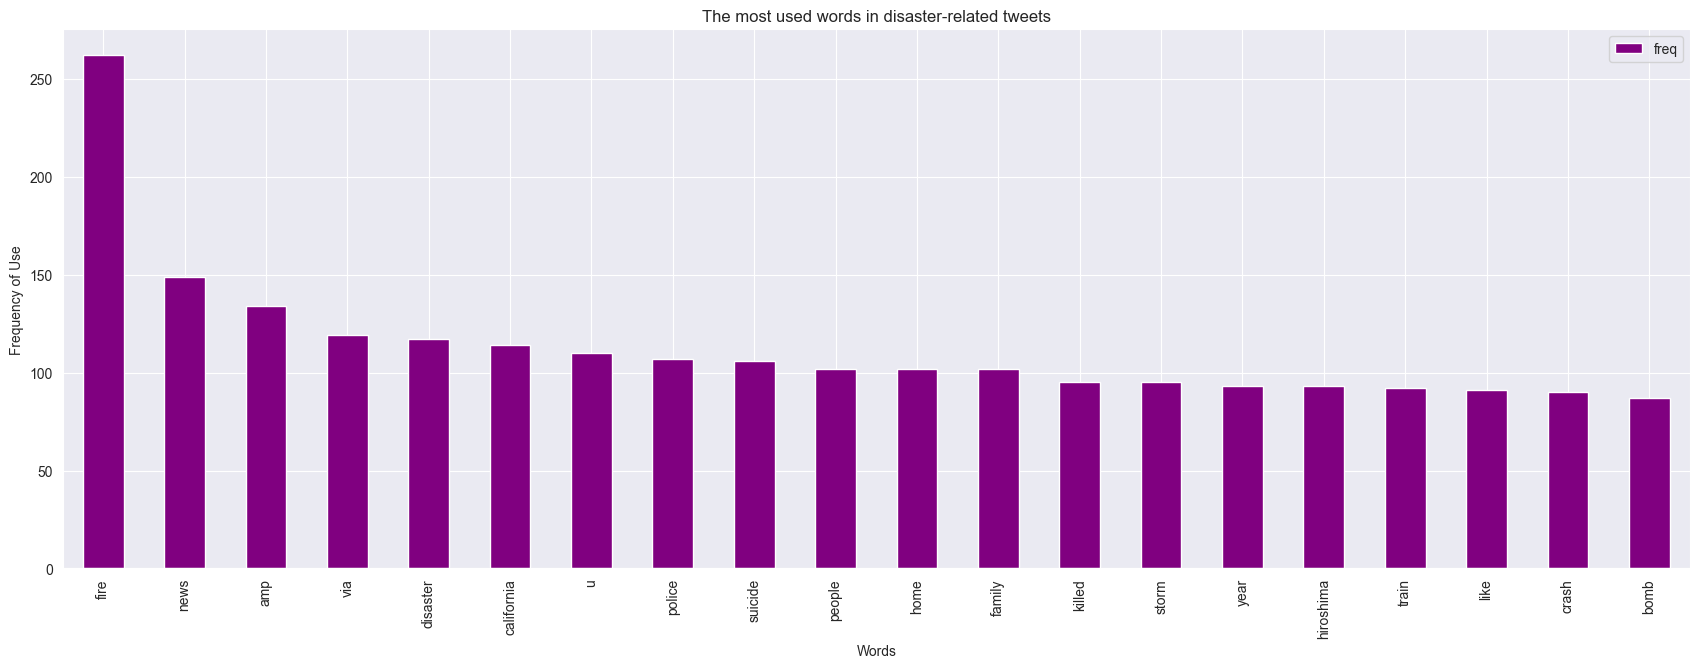

In [76]:
disaster_tweets_count_df.plot.bar(x="words", y="freq", figsize=(21,7), color="purple")
plt.title('The most used words in disaster-related tweets')
plt.xlabel('Words')
plt.ylabel('Frequency of Use');

In [77]:
disaster_text = " ".join(i for i in (df[df['target']==1]['text']))

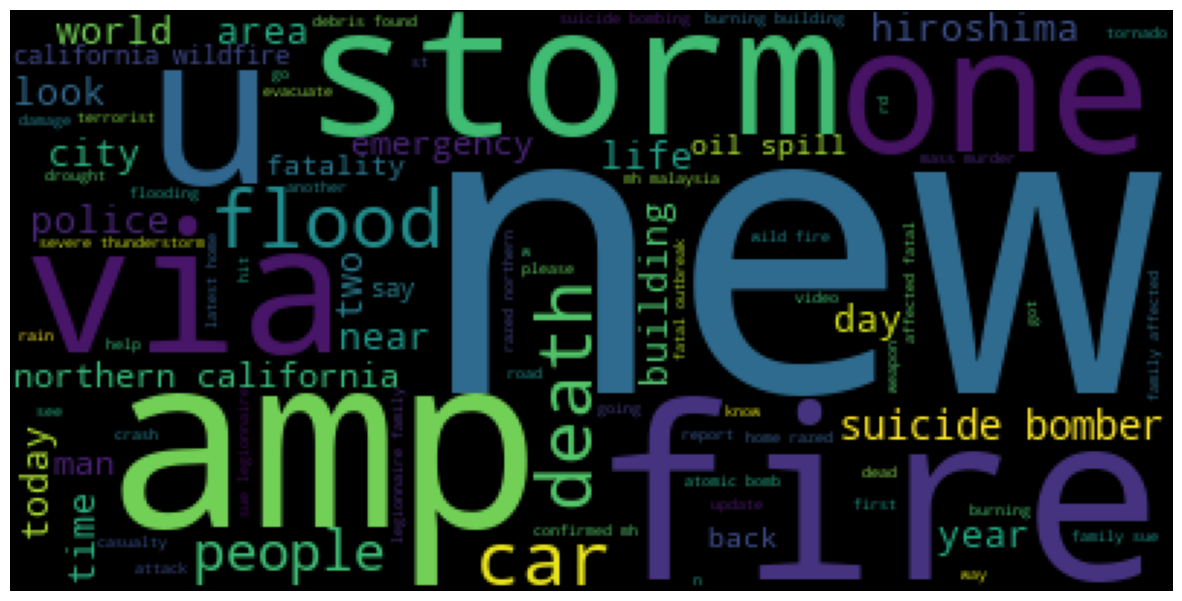

In [78]:
wordcloud = WordCloud(background_color= "black").generate(disaster_text)
plt.figure(figsize=[15,10])
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

In [79]:
non_disaster_text = " ".join(i for i in (df[df['target']==0]['text']))

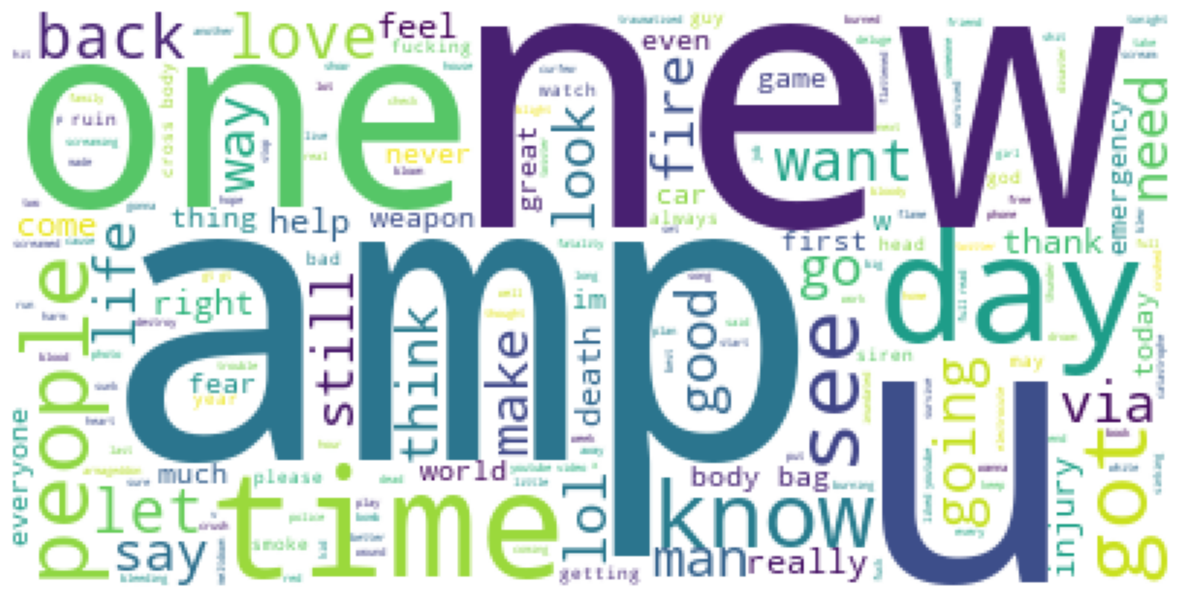

In [80]:
wordcloud = WordCloud(background_color= "white").generate(non_disaster_text)
plt.figure(figsize=[15,10])
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

# Count Vectors
# TF-IDF Vectors (words, characters, n-grams)
# Word Embeddings
# TF(t) = (Frequency of occurrence of a term t in a document) / (total number of terms in the document)
# IDF(t) = log_e(Total number of documents / number of documents containing term t)

In [81]:
y = df.target[:len(df_test)]
X = df.drop(["target","location"],axis=1)[:len(df_test)]

In [82]:
X, y

(      keyword                                               text
 0         221         deed reason earthquake may allah forgive u
 1         221              forest fire near la ronge sask canada
 2         221  resident asked shelter place notified officer ...
 3         221  people receive wildfire evacuation order calif...
 4         221  got sent photo ruby alaska smoke wildfire pour...
 ...       ...                                                ...
 3258       95  store fire alarm went today work evacuate like...
 3259       95  louis sad cancel show everyone leave evacuate ...
 3260       95              evacuate student throw dungeon stupid
 3261       95  u also flew bomb site world war ii warning let...
 3262       95  mygc broken powerlines evacuate gold coast tra...
 
 [3263 rows x 2 columns],
 0       1.0
 1       1.0
 2       1.0
 3       1.0
 4       1.0
        ... 
 3258    1.0
 3259    0.0
 3260    0.0
 3261    1.0
 3262    1.0
 Name: target, Length: 3263, dtype: f

In [83]:
X_train, X_test , y_train, y_test = model_selection.train_test_split(X, y, random_state=42, test_size=0.30)
X_train.head()

,keyword,text
1556,45,deep sleep dream bout fall cliff wake struggli...
435,11,casper rmg bestcomedyvine whats cracking cuz
1829,53,ina buted girl crush
237,5,fun filled happy hour simmons bar camden hands...
2820,82,heat wave relentless f feel like humidity rele...


# Count Vectors

In [85]:
vectorizer = CountVectorizer()
vectorizer.fit(X_train['text'])

CountVectorizer()

In [86]:
x_train_count = vectorizer.fit_transform(X_train['text'])
x_test_count = vectorizer.transform(X_test['text'])

In [88]:
vectorizer.get_feature_names_out()[:5]

array(['aa', 'aaaaaaallll', 'aace', 'aan', 'aaronthefm'], dtype=object)

In [89]:
x_train_count.toarray()

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

# TF- IDF
# Word Level TF-IDF

In [90]:
tf_idf_word_vectorizer = TfidfVectorizer()
tf_idf_word_vectorizer.fit(X_train['text'])
x_train_tf_idf_word = tf_idf_word_vectorizer.fit_transform(X_train['text'])
x_test_tf_idf_word = tf_idf_word_vectorizer.transform(X_test['text'])

In [92]:
tf_idf_word_vectorizer.get_feature_names_out()[:5]

array(['aa', 'aaaaaaallll', 'aace', 'aan', 'aaronthefm'], dtype=object)

# Ngram Level TF-IDF

In [93]:
tf_idf_ngram_vectorizer = TfidfVectorizer(ngram_range = (2,3))
tf_idf_ngram_vectorizer.fit(X_train['text'])
x_train_tf_idf_ngarm = tf_idf_ngram_vectorizer.fit_transform(X_train['text'])
x_test_tf_idf_ngram = tf_idf_ngram_vectorizer.transform(X_test['text'])

In [94]:
tf_idf_ngram_vectorizer.get_feature_names_out()[:5]

array(['aa battery', 'aa battery swear', 'aa mgm', 'aa mgm grand',
       'aaaaaaallll even'], dtype=object)

# Characters level TF-IDF

In [95]:
tf_idf_chars_vectorizer = TfidfVectorizer(analyzer = "char", ngram_range = (2,3))
tf_idf_chars_vectorizer.fit(X_train['text'])
x_train_tf_idf_chars = tf_idf_chars_vectorizer.fit_transform(X_train['text'])
x_test_tf_idf_chars = tf_idf_chars_vectorizer.transform(X_test['text'])

In [96]:
tf_idf_chars_vectorizer.get_feature_names_out()[:5]

array([' a', ' aa', ' ab', ' ac', ' ad'], dtype=object)

# Creating a Model

In [97]:
all_performances = pd.DataFrame()
list_clf_name = []
list_x_test = []
list_pred = []
list_model = []

In [98]:
def fit_model(model, x_train_x, y_train):
    x_model = model.fit(x_train_x,y_train)
    return x_model

In [99]:
def model_name(model, vector_name):
    model_name= model.__class__.__name__
    if vector_name == "c":
        return model_name+"_count"
    elif vector_name == "n":
        return model_name+"_ngram"
    elif vector_name == "w":
        return model_name+"_word"
    elif vector_name == "ch":
        return model_name+"_chars"
    else:
        return

In [100]:
def add_list(name, model, x_test_x, y_pred):
    global list_clf_name, list_pred, list_model, list_x_test
    list_clf_name.append(name)
    list_model.append(model)
    list_x_test.append(x_test_x)
    list_pred.append(y_pred)

In [104]:
def add_all_performances(name, training_set_score, test_set_score, precision, recall, f1_score, AUC):
    global all_performances
    models = pd.DataFrame([[name, training_set_score, test_set_score, precision, recall, f1_score, AUC]],
                         columns=["model_name","training_set_score", "test_set_score",
                                  "precision", "recall", "f1_score", "AUC"])
    all_performances = pd.concat([all_performances, models], ignore_index=True)
    all_performances= all_performances.drop_duplicates()

In [105]:
def model_performance(x_train_x, x_test_x, model, vector_name):
    
    x_model = fit_model(model, x_train_x, y_train)
    
    name = model_name(model, vector_name)
    y_pred = x_model.predict(x_test_x)
    training_set_score= x_model.score(x_train_x, y_train)
    test_set_score = x_model.score(x_test_x, y_test)
    precision = mt.precision_score(y_test,y_pred)
    recall = mt.recall_score(y_test,y_pred)
    f1_score= mt.f1_score(y_test, y_pred)
    AUC = roc_auc_score(y_test, y_pred) 
    
    add_list(name, model, x_test_x, y_pred)
    add_all_performances(name, training_set_score, test_set_score, precision, recall, f1_score, AUC)
    
    print(classification_report(y_test, y_pred, target_names=['non-disaster','disaster']))

# Logistic Regression

In [106]:
log_reg = linear_model.LogisticRegression()
model_performance(x_train_count, x_test_count, log_reg, "c")

              precision    recall  f1-score   support

non-disaster       0.82      0.89      0.85       609
    disaster       0.79      0.67      0.72       370

    accuracy                           0.81       979
   macro avg       0.80      0.78      0.79       979
weighted avg       0.81      0.81      0.80       979


In [107]:
log_reg = linear_model.LogisticRegression()
model_performance(x_train_tf_idf_word, x_test_tf_idf_word, log_reg, "w")

              precision    recall  f1-score   support

non-disaster       0.80      0.93      0.86       609
    disaster       0.85      0.63      0.72       370

    accuracy                           0.82       979
   macro avg       0.83      0.78      0.79       979
weighted avg       0.82      0.82      0.81       979


In [108]:
log_reg = linear_model.LogisticRegression()
model_performance(x_train_tf_idf_ngarm, x_test_tf_idf_ngram, log_reg, "n")

              precision    recall  f1-score   support

non-disaster       0.71      0.97      0.82       609
    disaster       0.88      0.34      0.49       370

    accuracy                           0.73       979
   macro avg       0.79      0.66      0.66       979
weighted avg       0.77      0.73      0.70       979


In [109]:
log_reg = linear_model.LogisticRegression()
model_performance(x_train_tf_idf_chars, x_test_tf_idf_chars, log_reg, "ch")

              precision    recall  f1-score   support

non-disaster       0.80      0.89      0.84       609
    disaster       0.77      0.63      0.70       370

    accuracy                           0.79       979
   macro avg       0.79      0.76      0.77       979
weighted avg       0.79      0.79      0.79       979


# Naive Bayes

In [110]:
nb = naive_bayes.MultinomialNB()
model_performance(x_train_count, x_test_count, nb, "c")

              precision    recall  f1-score   support

non-disaster       0.83      0.84      0.84       609
    disaster       0.73      0.72      0.73       370

    accuracy                           0.80       979
   macro avg       0.78      0.78      0.78       979
weighted avg       0.79      0.80      0.80       979


In [111]:
nb = naive_bayes.MultinomialNB()
model_performance(x_train_tf_idf_word, x_test_tf_idf_word, nb, "w")

              precision    recall  f1-score   support

non-disaster       0.81      0.93      0.87       609
    disaster       0.85      0.64      0.73       370

    accuracy                           0.82       979
   macro avg       0.83      0.79      0.80       979
weighted avg       0.82      0.82      0.82       979


In [112]:
nb = naive_bayes.MultinomialNB()
model_performance(x_train_tf_idf_ngarm, x_test_tf_idf_ngram, nb, "n")

              precision    recall  f1-score   support

non-disaster       0.73      0.96      0.83       609
    disaster       0.88      0.42      0.57       370

    accuracy                           0.76       979
   macro avg       0.81      0.69      0.70       979
weighted avg       0.79      0.76      0.73       979


In [113]:
nb = naive_bayes.MultinomialNB()
model_performance(x_train_tf_idf_chars, x_test_tf_idf_chars, nb, "ch")

              precision    recall  f1-score   support

non-disaster       0.76      0.95      0.84       609
    disaster       0.85      0.51      0.64       370

    accuracy                           0.78       979
   macro avg       0.81      0.73      0.74       979
weighted avg       0.80      0.78      0.77       979


# Random Forests

In [114]:
rf = ensemble.RandomForestClassifier()
model_performance(x_train_count, x_test_count, rf, "c")

              precision    recall  f1-score   support

non-disaster       0.80      0.90      0.84       609
    disaster       0.79      0.63      0.70       370

    accuracy                           0.79       979
   macro avg       0.79      0.76      0.77       979
weighted avg       0.79      0.79      0.79       979


In [115]:
rf = ensemble.RandomForestClassifier()
model_performance(x_train_tf_idf_word, x_test_tf_idf_word, rf, "w")

              precision    recall  f1-score   support

non-disaster       0.81      0.90      0.85       609
    disaster       0.79      0.66      0.72       370

    accuracy                           0.81       979
   macro avg       0.80      0.78      0.79       979
weighted avg       0.80      0.81      0.80       979


In [116]:
rf = ensemble.RandomForestClassifier()
model_performance(x_train_tf_idf_ngarm, x_test_tf_idf_ngram, rf, "n")

              precision    recall  f1-score   support

non-disaster       0.70      0.96      0.81       609
    disaster       0.83      0.34      0.48       370

    accuracy                           0.72       979
   macro avg       0.77      0.65      0.65       979
weighted avg       0.75      0.72      0.69       979


In [121]:
rf = ensemble.RandomForestClassifier()
model_performance(x_train_tf_idf_chars, x_test_tf_idf_chars, rf, "ch")

              precision    recall  f1-score   support

non-disaster       0.77      0.91      0.84       609
    disaster       0.79      0.55      0.65       370

    accuracy                           0.78       979
   macro avg       0.78      0.73      0.74       979
weighted avg       0.78      0.78      0.77       979


# XGBoost

In [122]:
xgb = xgboost.XGBClassifier()
model_performance(x_train_count, x_test_count, xgb, "c")

              precision    recall  f1-score   support

non-disaster       0.81      0.91      0.86       609
    disaster       0.82      0.64      0.72       370

    accuracy                           0.81       979
   macro avg       0.81      0.78      0.79       979
weighted avg       0.81      0.81      0.81       979


In [123]:
xgb = xgboost.XGBClassifier()
model_performance(x_train_tf_idf_word, x_test_tf_idf_word, xgb, "w")

              precision    recall  f1-score   support

non-disaster       0.79      0.90      0.85       609
    disaster       0.80      0.61      0.69       370

    accuracy                           0.79       979
   macro avg       0.80      0.76      0.77       979
weighted avg       0.79      0.79      0.79       979


In [124]:
xgb = xgboost.XGBClassifier()
model_performance(x_train_tf_idf_ngarm, x_test_tf_idf_ngram, xgb, "n")

              precision    recall  f1-score   support

non-disaster       0.67      0.96      0.79       609
    disaster       0.79      0.24      0.37       370

    accuracy                           0.69       979
   macro avg       0.73      0.60      0.58       979
weighted avg       0.72      0.69      0.63       979


In [125]:
xgb = xgboost.XGBClassifier()
model_performance(x_train_tf_idf_chars, x_test_tf_idf_chars, xgb, "ch")

              precision    recall  f1-score   support

non-disaster       0.79      0.82      0.81       609
    disaster       0.68      0.65      0.67       370

    accuracy                           0.75       979
   macro avg       0.74      0.73      0.74       979
weighted avg       0.75      0.75      0.75       979


# SVC

In [126]:
svc = svm.SVC()
model_performance(x_train_count, x_test_count, svc, "c")

              precision    recall  f1-score   support

non-disaster       0.79      0.94      0.86       609
    disaster       0.86      0.59      0.70       370

    accuracy                           0.81       979
   macro avg       0.83      0.77      0.78       979
weighted avg       0.82      0.81      0.80       979


In [127]:
svc = svm.SVC()
model_performance(x_train_tf_idf_word, x_test_tf_idf_word, svc, "w")

              precision    recall  f1-score   support

non-disaster       0.80      0.94      0.86       609
    disaster       0.86      0.61      0.72       370

    accuracy                           0.82       979
   macro avg       0.83      0.78      0.79       979
weighted avg       0.82      0.82      0.81       979


In [128]:
svc = svm.SVC()
model_performance(x_train_tf_idf_ngarm, x_test_tf_idf_ngram, svc, "n")

              precision    recall  f1-score   support

non-disaster       0.70      0.97      0.82       609
    disaster       0.87      0.33      0.48       370

    accuracy                           0.73       979
   macro avg       0.79      0.65      0.65       979
weighted avg       0.77      0.73      0.69       979


In [129]:
svc = svm.SVC()
model_performance(x_train_tf_idf_chars, x_test_tf_idf_chars, svc, "ch")

              precision    recall  f1-score   support

non-disaster       0.79      0.90      0.84       609
    disaster       0.78      0.61      0.69       370

    accuracy                           0.79       979
   macro avg       0.79      0.75      0.76       979
weighted avg       0.79      0.79      0.78       979


# SGDClassifier

In [130]:
sgdc = linear_model.SGDClassifier()
model_performance(x_train_count, x_test_count, sgdc, "c")

              precision    recall  f1-score   support

non-disaster       0.81      0.84      0.82       609
    disaster       0.72      0.67      0.69       370

    accuracy                           0.78       979
   macro avg       0.76      0.75      0.76       979
weighted avg       0.77      0.78      0.77       979


In [131]:
sgdc = linear_model.SGDClassifier()
model_performance(x_train_tf_idf_word, x_test_tf_idf_word, sgdc, "w")

              precision    recall  f1-score   support

non-disaster       0.82      0.82      0.82       609
    disaster       0.71      0.71      0.71       370

    accuracy                           0.78       979
   macro avg       0.77      0.77      0.77       979
weighted avg       0.78      0.78      0.78       979


In [132]:
sgdc = linear_model.SGDClassifier()
model_performance(x_train_tf_idf_ngarm, x_test_tf_idf_ngram, sgdc, "n")

              precision    recall  f1-score   support

non-disaster       0.74      0.92      0.82       609
    disaster       0.79      0.48      0.59       370

    accuracy                           0.75       979
   macro avg       0.77      0.70      0.71       979
weighted avg       0.76      0.75      0.74       979


In [133]:
sgdc = linear_model.SGDClassifier()
model_performance(x_train_tf_idf_chars, x_test_tf_idf_chars, sgdc, "ch")

              precision    recall  f1-score   support

non-disaster       0.81      0.79      0.80       609
    disaster       0.67      0.69      0.68       370

    accuracy                           0.75       979
   macro avg       0.74      0.74      0.74       979
weighted avg       0.75      0.75      0.75       979


# Performance Evaluation

In [138]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, roc_auc_score

def display_all_confusion_matrix():
    num_classifiers = len(list_clf_name)
    cols = 4
    rows = -(-num_classifiers // cols)
    
    f, ax = plt.subplots(rows, cols, figsize=(20, rows * 5), sharey='row')
    ax = ax.flatten()

    for i in range(len(list_clf_name)):
        cf_matrix = confusion_matrix(y_test, list_pred[i])
        disp = ConfusionMatrixDisplay(cf_matrix)
        disp.plot(ax=ax[i], xticks_rotation=45)
        disp.ax_.set_title(list_clf_name[i]+"\nAccuracy:{accuracy:.4f}\nAUC:{auc:.4f}"
                           .format(accuracy= accuracy_score(y_test, list_pred[i]),auc= roc_auc_score(y_test, list_pred[i])),
                             fontsize=14)
        disp.im_.colorbar.remove()
        disp.ax_.set_xlabel('')
        if i!=0:
            disp.ax_.set_ylabel('')


    for j in range(num_classifiers, len(ax)):
        f.delaxes(ax[j])

    f.text(0.5, 0.04, 'Predicted label', ha='center', fontsize=16)
    f.text(0.04, 0.5, 'True label', va='center', rotation='vertical', fontsize=16)
    plt.subplots_adjust(hspace=0.4, wspace=0.3)

    cbar_ax = f.add_axes([0.92, 0.15, 0.02, 0.7])
    f.colorbar(disp.im_, cax=cbar_ax)
    plt.show()

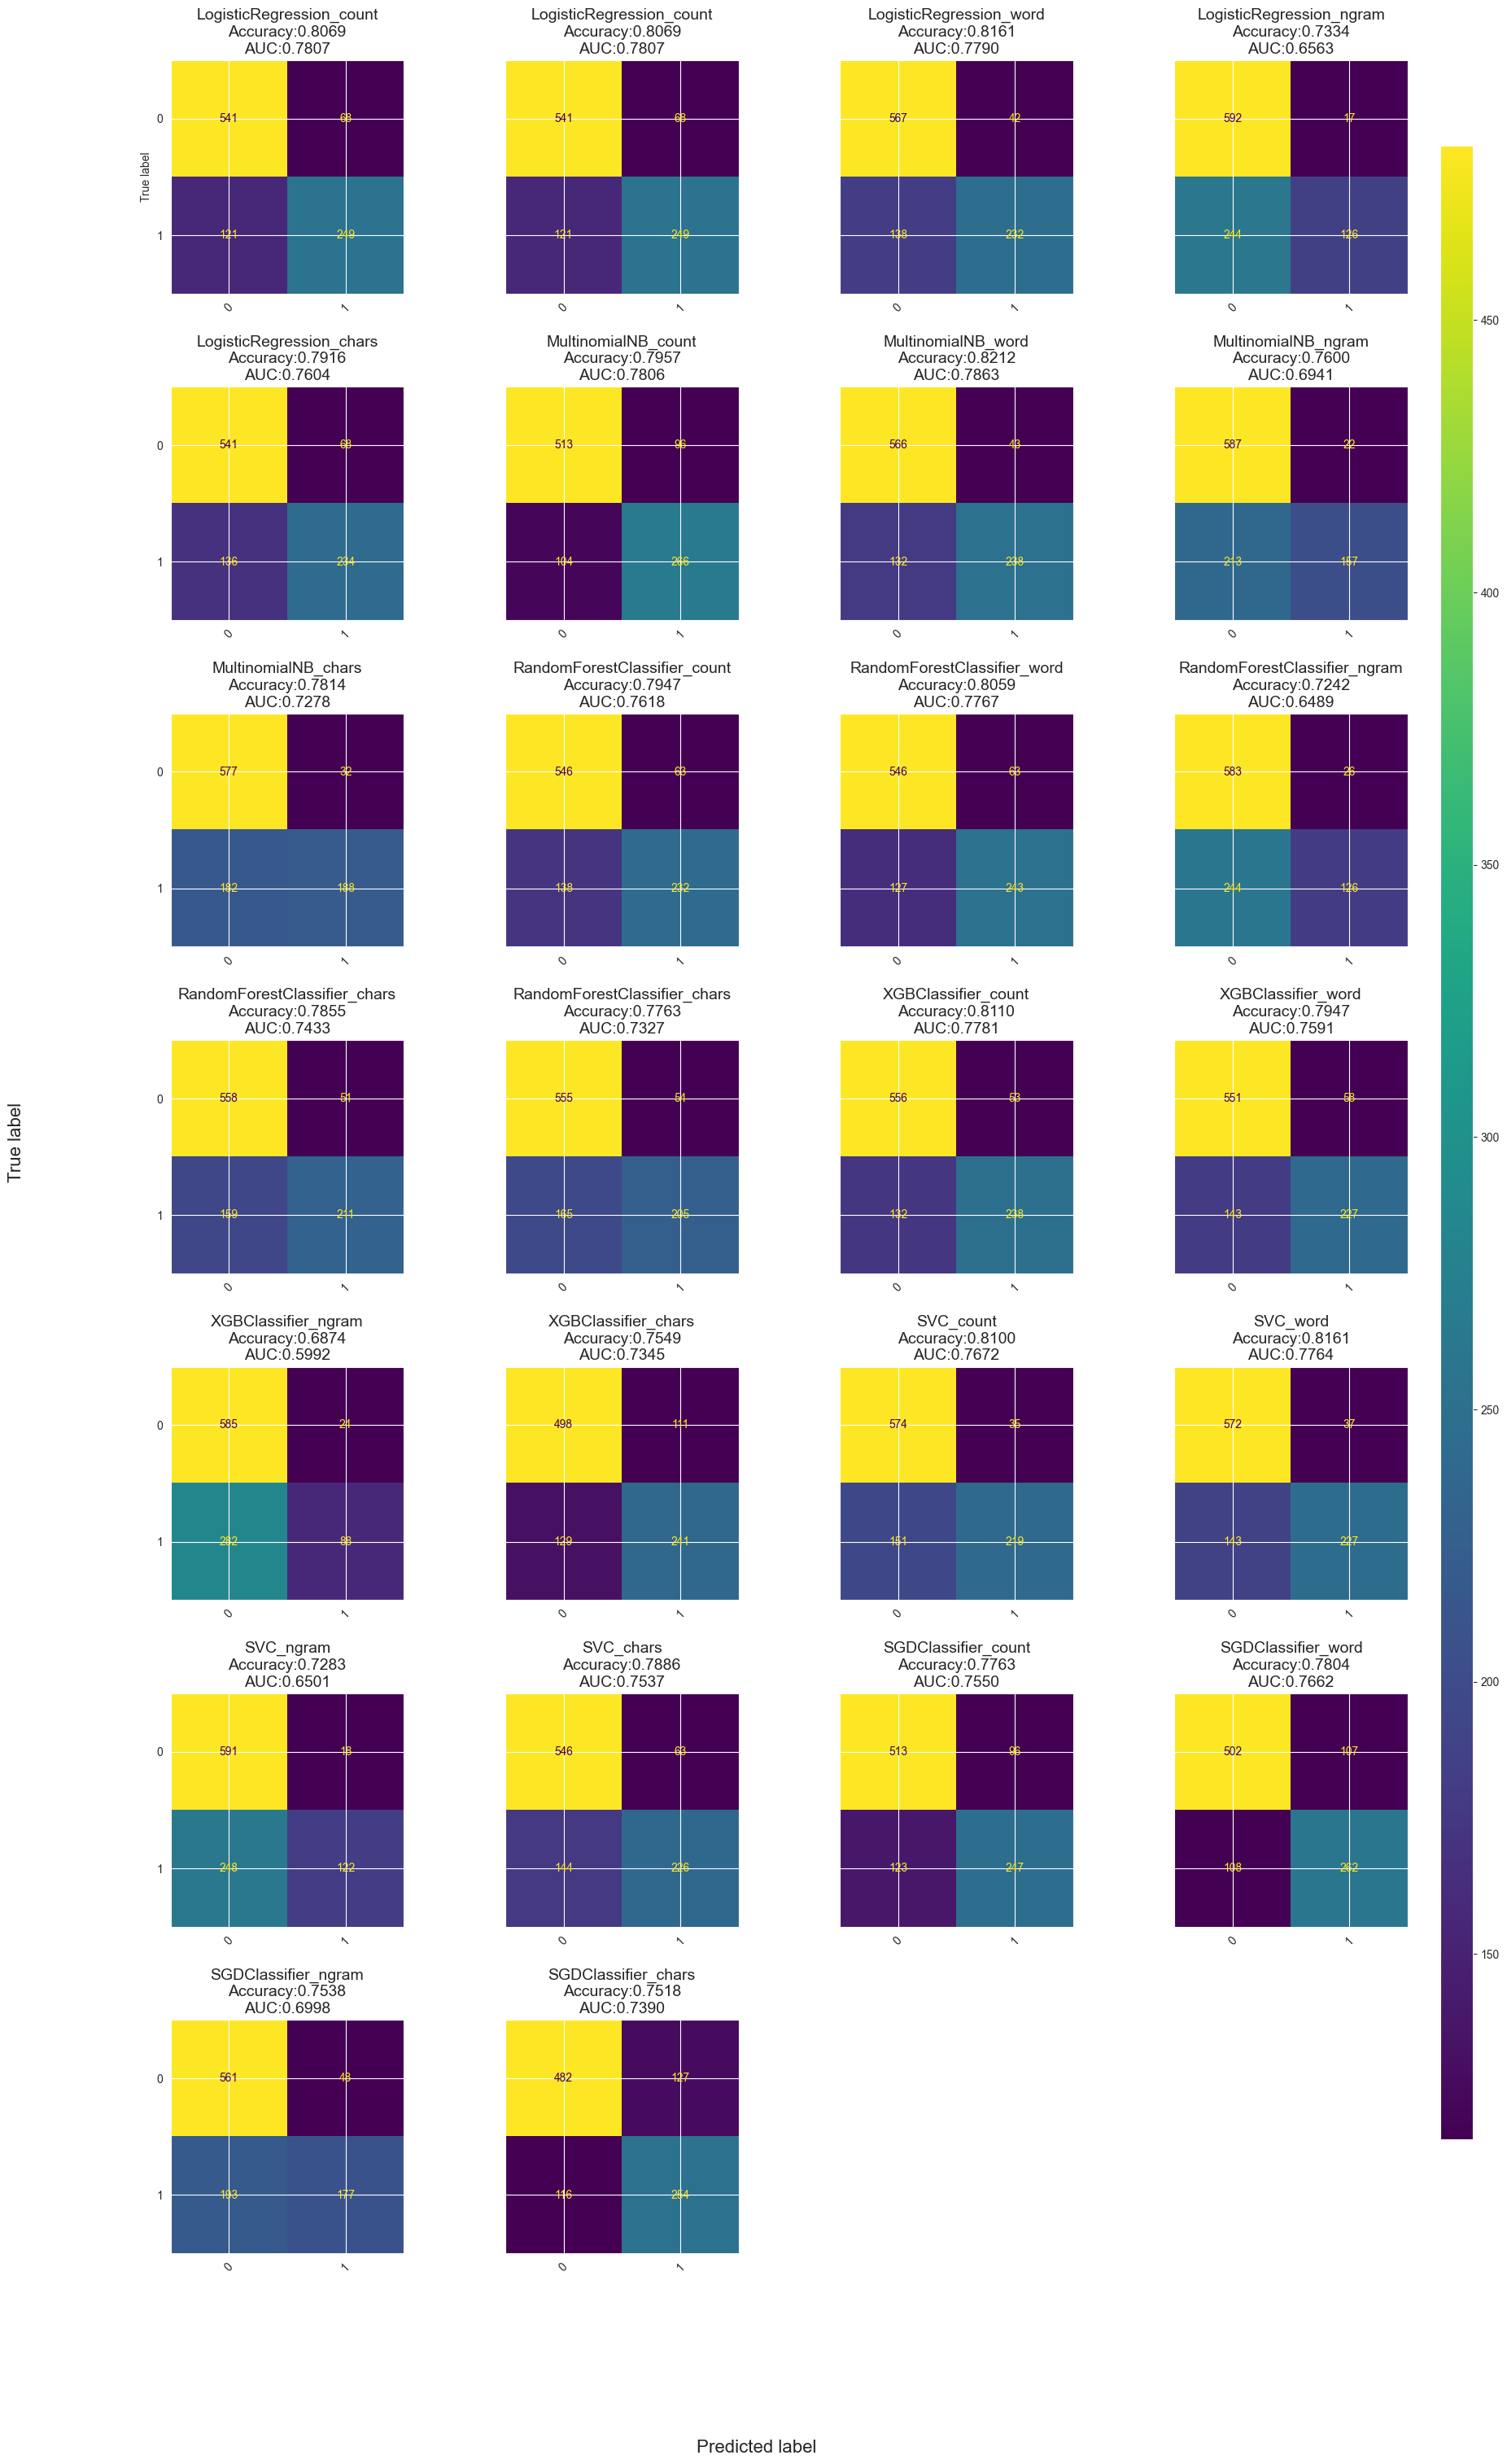

In [139]:
display_all_confusion_matrix()

In [140]:
all_performances.sort_values(by=['f1_score'], ascending=False)

,model_name,training_set_score,test_set_score,precision,recall,f1_score,AUC
5,MultinomialNB_word,0.920315,0.821246,0.846975,0.643243,0.731183,0.786318
4,MultinomialNB_count,0.941769,0.795710,0.734807,0.718919,0.726776,0.780642
0,LogisticRegression_count,0.975919,0.806946,0.785489,0.672973,0.724891,0.780657
1,LogisticRegression_word,0.894046,0.816139,0.846715,0.627027,0.720497,0.779031
13,XGBClassifier_count,0.854641,0.811032,0.817869,0.643243,0.720121,0.778108
9,RandomForestClassifier_word,0.991681,0.805924,0.794118,0.656757,0.718935,0.776654
18,SVC_word,0.979860,0.816139,0.859848,0.613514,0.716088,0.776379
22,SGDClassifier_word,0.988179,0.780388,0.710027,0.708108,0.709066,0.766205
17,SVC_count,0.956217,0.810010,0.862205,0.591892,0.701923,0.767210
8,RandomForestClassifier_count,0.991681,0.794688,0.786441,0.627027,0.697744,0.761789


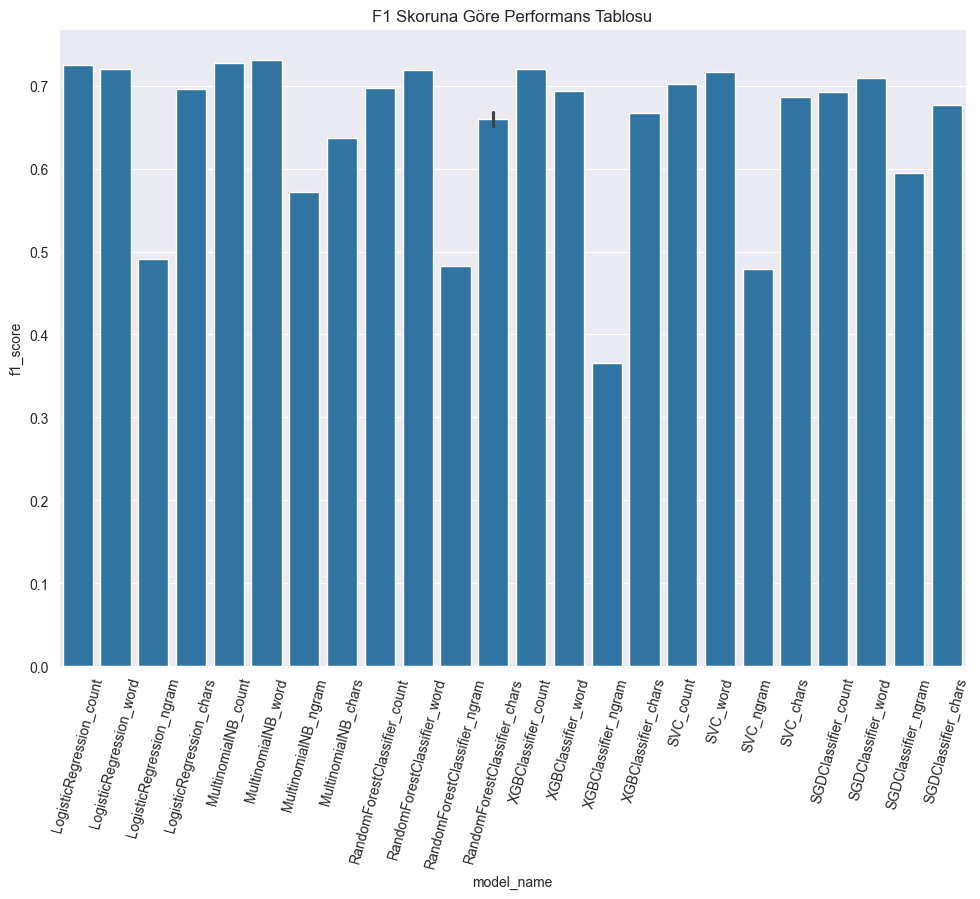

In [141]:
a4_dims = (11.7, 8.27)
fig, ax = plt.subplots(figsize=a4_dims)
plt.xticks(rotation=75)
sns.barplot(x="model_name", y ="f1_score", data = all_performances, ax=ax);
title = plt.title('F1 Skoruna Göre Performans Tablosu')

# Hyperparameter Tuning
# Naive Bayes

In [142]:
param_grid = {
    'alpha': [11.25,11.5,11.75],  # smoothing parameter
    'fit_prior': [True, False],  # whether to learn class prior probabilities or use uniform priors
    'class_prior': [None, [0.3, 0.7], [0.5, 0.5]],  # prior probabilities of the classes
}

In [143]:
classifier = naive_bayes.MultinomialNB()

In [144]:
# Perform grid search with cross-validation
grid_search = GridSearchCV(estimator=classifier, param_grid=param_grid, cv=5, scoring='accuracy',
                           verbose=2)

# Count Vector

In [145]:
grid_search.fit(x_train_count, y_train)

Fitting 5 folds for each of 18 candidates, totalling 90 fits
[CV] END ......alpha=11.25, class_prior=None, fit_prior=True; total time=   0.0s
[CV] END ......alpha=11.25, class_prior=None, fit_prior=True; total time=   0.0s
[CV] END ......alpha=11.25, class_prior=None, fit_prior=True; total time=   0.0s
[CV] END ......alpha=11.25, class_prior=None, fit_prior=True; total time=   0.0s
[CV] END ......alpha=11.25, class_prior=None, fit_prior=True; total time=   0.0s
[CV] END .....alpha=11.25, class_prior=None, fit_prior=False; total time=   0.0s
[CV] END .....alpha=11.25, class_prior=None, fit_prior=False; total time=   0.0s
[CV] END .....alpha=11.25, class_prior=None, fit_prior=False; total time=   0.0s
[CV] END .....alpha=11.25, class_prior=None, fit_prior=False; total time=   0.0s
[CV] END .....alpha=11.25, class_prior=None, fit_prior=False; total time=   0.0s
[CV] END alpha=11.25, class_prior=[0.3, 0.7], fit_prior=True; total time=   0.0s
[CV] END alpha=11.25, class_prior=[0.3, 0.7], fi

GridSearchCV(cv=5, estimator=MultinomialNB(),
             param_grid={'alpha': [11.25, 11.5, 11.75],
                         'class_prior': [None, [0.3, 0.7], [0.5, 0.5]],
                         'fit_prior': [True, False]},
             scoring='accuracy', verbose=2)

In [146]:
# Print the best parameter combination and score
print("Best Parameters: ", grid_search.best_params_)
print("Best Score: ", grid_search.best_score_)

Best Parameters:  {'alpha': 11.75, 'class_prior': None, 'fit_prior': True}
Best Score:  0.7859006103881148


In [147]:
best_classifier = grid_search.best_estimator_
accuracy = best_classifier.score(x_test_count, y_test)
print("Test Accuracy:", accuracy)

Test Accuracy: 0.8161389172625128


# Word Level TF-IDF

In [148]:
grid_search.fit(x_train_tf_idf_word, y_train)

Fitting 5 folds for each of 18 candidates, totalling 90 fits
[CV] END ......alpha=11.25, class_prior=None, fit_prior=True; total time=   0.0s
[CV] END ......alpha=11.25, class_prior=None, fit_prior=True; total time=   0.0s
[CV] END ......alpha=11.25, class_prior=None, fit_prior=True; total time=   0.0s
[CV] END ......alpha=11.25, class_prior=None, fit_prior=True; total time=   0.0s
[CV] END ......alpha=11.25, class_prior=None, fit_prior=True; total time=   0.0s
[CV] END .....alpha=11.25, class_prior=None, fit_prior=False; total time=   0.0s
[CV] END .....alpha=11.25, class_prior=None, fit_prior=False; total time=   0.0s
[CV] END .....alpha=11.25, class_prior=None, fit_prior=False; total time=   0.0s
[CV] END .....alpha=11.25, class_prior=None, fit_prior=False; total time=   0.0s
[CV] END .....alpha=11.25, class_prior=None, fit_prior=False; total time=   0.0s
[CV] END alpha=11.25, class_prior=[0.3, 0.7], fit_prior=True; total time=   0.0s
[CV] END alpha=11.25, class_prior=[0.3, 0.7], fi

GridSearchCV(cv=5, estimator=MultinomialNB(),
             param_grid={'alpha': [11.25, 11.5, 11.75],
                         'class_prior': [None, [0.3, 0.7], [0.5, 0.5]],
                         'fit_prior': [True, False]},
             scoring='accuracy', verbose=2)

In [149]:
# Print the best parameter combination and score
print("Best Parameters: ", grid_search.best_params_)
print("Best Score: ", grid_search.best_score_)

Best Parameters:  {'alpha': 11.5, 'class_prior': None, 'fit_prior': False}
Best Score:  0.767500671810818


# SVC (Word Level TF-IDF)

In [150]:
param_grid = {
    'C': [0.5, 1.0, 1.5],  # regularization parameter
    'kernel': ['linear', 'rbf'],  # kernel type
    'gamma': ['scale', 'auto']  # kernel coefficient for 'rbf'
}

In [151]:
classifier = SVC()

In [152]:
grid_search = GridSearchCV(estimator=classifier, param_grid=param_grid, cv=5, scoring='accuracy',
                           verbose=2)

In [153]:
grid_search.fit(x_train_tf_idf_word, y_train)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV] END ..................C=0.5, gamma=scale, kernel=linear; total time=   0.2s
[CV] END ..................C=0.5, gamma=scale, kernel=linear; total time=   0.1s
[CV] END ..................C=0.5, gamma=scale, kernel=linear; total time=   0.2s
[CV] END ..................C=0.5, gamma=scale, kernel=linear; total time=   0.2s
[CV] END ..................C=0.5, gamma=scale, kernel=linear; total time=   0.1s
[CV] END .....................C=0.5, gamma=scale, kernel=rbf; total time=   0.2s
[CV] END .....................C=0.5, gamma=scale, kernel=rbf; total time=   0.2s
[CV] END .....................C=0.5, gamma=scale, kernel=rbf; total time=   0.2s
[CV] END .....................C=0.5, gamma=scale, kernel=rbf; total time=   0.2s
[CV] END .....................C=0.5, gamma=scale, kernel=rbf; total time=   0.2s
[CV] END ...................C=0.5, gamma=auto, kernel=linear; total time=   0.2s
[CV] END ...................C=0.5, gamma=auto, k

GridSearchCV(cv=5, estimator=SVC(),
             param_grid={'C': [0.5, 1.0, 1.5], 'gamma': ['scale', 'auto'],
                         'kernel': ['linear', 'rbf']},
             scoring='accuracy', verbose=2)

In [154]:
# Print the best parameter combination and score
print("Best Parameters: ", grid_search.best_params_)
print("Best Score: ", grid_search.best_score_)

Best Parameters:  {'C': 1.5, 'gamma': 'scale', 'kernel': 'rbf'}
Best Score:  0.7780260278705515


# Logistic Regression (Count Vector)

In [155]:
param_grid = {
    'C': [0.25,0.3,0.35],  # inverse regularization strength
    'penalty': ['l1', 'l2'],  # regularization type
    'solver': ['liblinear', 'saga']  # optimization algorithm
}

In [156]:
classifier = linear_model.LogisticRegression()

In [157]:
# Perform grid search with cross-validation
grid_search = GridSearchCV(estimator=classifier, param_grid=param_grid, cv=5, scoring='accuracy',
                           verbose=2)
grid_search.fit(x_train_count, y_train)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV] END ...............C=0.25, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END ...............C=0.25, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END ...............C=0.25, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END ...............C=0.25, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END ...............C=0.25, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END ....................C=0.25, penalty=l1, solver=saga; total time=   0.0s
[CV] END ....................C=0.25, penalty=l1, solver=saga; total time=   0.0s
[CV] END ....................C=0.25, penalty=l1, solver=saga; total time=   0.0s
[CV] END ....................C=0.25, penalty=l1, solver=saga; total time=   0.0s
[CV] END ....................C=0.25, penalty=l1, solver=saga; total time=   0.0s
[CV] END ...............C=0.25, penalty=l2, solver=liblinear; total time=   0.0s
[CV] END ...............C=0.25, penalty=l2, solv

GridSearchCV(cv=5, estimator=LogisticRegression(),
             param_grid={'C': [0.25, 0.3, 0.35], 'penalty': ['l1', 'l2'],
                         'solver': ['liblinear', 'saga']},
             scoring='accuracy', verbose=2)

In [158]:
# Print the best parameter combination and score
print("Best Parameters: ", grid_search.best_params_)
print("Best Score: ", grid_search.best_score_)

Best Parameters:  {'C': 0.25, 'penalty': 'l2', 'solver': 'saga'}
Best Score:  0.7867806825597911


# Best Performing Model

In [159]:
best_classifier = grid_search.best_estimator_

In [160]:
best_classifier

LogisticRegression(C=0.25, solver='saga')

In [161]:
model_performance(x_train_count, x_test_count, best_classifier, "c_tuned")

              precision    recall  f1-score   support

non-disaster       0.81      0.92      0.86       609
    disaster       0.83      0.66      0.73       370

    accuracy                           0.82       979
   macro avg       0.82      0.79      0.80       979
weighted avg       0.82      0.82      0.81       979


In [162]:
all_performances.sort_values(by=['f1_score'], ascending=False)

,model_name,training_set_score,test_set_score,precision,recall,f1_score,AUC
25,None,0.929510,0.818182,0.826531,0.656757,0.731928,0.786506
5,MultinomialNB_word,0.920315,0.821246,0.846975,0.643243,0.731183,0.786318
4,MultinomialNB_count,0.941769,0.795710,0.734807,0.718919,0.726776,0.780642
0,LogisticRegression_count,0.975919,0.806946,0.785489,0.672973,0.724891,0.780657
1,LogisticRegression_word,0.894046,0.816139,0.846715,0.627027,0.720497,0.779031
13,XGBClassifier_count,0.854641,0.811032,0.817869,0.643243,0.720121,0.778108
9,RandomForestClassifier_word,0.991681,0.805924,0.794118,0.656757,0.718935,0.776654
18,SVC_word,0.979860,0.816139,0.859848,0.613514,0.716088,0.776379
22,SGDClassifier_word,0.988179,0.780388,0.710027,0.708108,0.709066,0.766205
17,SVC_count,0.956217,0.810010,0.862205,0.591892,0.701923,0.767210


In [163]:
df

,keyword,location,text,target
0,221,no_{col},deed reason earthquake may allah forgive u,1.0
1,221,no_{col},forest fire near la ronge sask canada,1.0
2,221,no_{col},resident asked shelter place notified officer ...,1.0
3,221,no_{col},people receive wildfire evacuation order calif...,1.0
4,221,no_{col},got sent photo ruby alaska smoke wildfire pour...,1.0
...,...,...,...,...
10743,221,no_{col},eahquake safety los angeles safety fastener xrwn,NaN
10744,221,no_{col},storm ri worse last hurricane city amp others ...,NaN
10745,221,no_{col},green line derailment chicago,NaN
10746,221,no_{col},meg issue hazardous weather outlook hwo,NaN


In [164]:
X_pred = df[len(df_train):].drop("target",axis=1)
X_pred["text"]

7485                           happened terrible car crash
7486     heard earthquake different city stay safe ever...
7487     forest fire spot pond goose fleeing across str...
7488                  apocalypse lighting spokane wildfire
7489                    typhoon soudelor kill china taiwan
                               ...                        
10743     eahquake safety los angeles safety fastener xrwn
10744    storm ri worse last hurricane city amp others ...
10745                        green line derailment chicago
10746              meg issue hazardous weather outlook hwo
10747    cityofcalgary activated municipal emergency pl...
Name: text, Length: 3263, dtype: object

In [165]:
X_train['text']

1556    deep sleep dream bout fall cliff wake struggli...
435          casper rmg bestcomedyvine whats cracking cuz
1829                                 ina buted girl crush
237     fun filled happy hour simmons bar camden hands...
2820    heat wave relentless f feel like humidity rele...
                              ...                        
1095    st august turkish jet bombed village zergele q...
1130    cryptic guided pilot hiroshima bombing mission...
1294                kanger coil burning fast via r vaping
860                                                 blood
3174    emergency service unsure cope loss paging network
Name: text, Length: 2284, dtype: object

In [166]:
vectorizer = CountVectorizer()
vectorizer.fit_transform(X_train['text'])

<Compressed Sparse Row sparse matrix of dtype 'int64'
	with 20139 stored elements and shape (2284, 6948)>

In [167]:
X_pred_count = vectorizer.transform(X_pred["text"])

In [168]:
vectorizer.get_feature_names_out()[:5]

array(['aa', 'aaaaaaallll', 'aace', 'aan', 'aaronthefm'], dtype=object)

In [169]:
X_pred_count.toarray()

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [170]:
X_pred_count.shape

(3263, 6948)

In [171]:
x_train_count.shape

(2284, 6948)

In [172]:
y_pred = best_classifier.predict(X_pred_count)

In [173]:
sample_submission["target"].shape

(3263,)

In [174]:
X_pred["text"].shape

(3263,)

In [175]:
y_pred.shape

(3263,)

In [176]:
data = {'tweet': X_pred["text"], 'location': X_pred['location'] , 'predicted_label': y_pred}
predicted_data = pd.DataFrame(data).reset_index(drop=True)

In [177]:
predicted_data['actual_label'] = sample_submission["target"].reset_index(drop=True)

In [178]:
predicted_data

,tweet,location,predicted_label,actual_label
0,happened terrible car crash,no_{col},0.0,0
1,heard earthquake different city stay safe ever...,no_{col},1.0,0
2,forest fire spot pond goose fleeing across str...,no_{col},1.0,0
3,apocalypse lighting spokane wildfire,no_{col},1.0,0
4,typhoon soudelor kill china taiwan,no_{col},0.0,0
...,...,...,...,...
3258,eahquake safety los angeles safety fastener xrwn,no_{col},0.0,0
3259,storm ri worse last hurricane city amp others ...,no_{col},1.0,0
3260,green line derailment chicago,no_{col},1.0,0
3261,meg issue hazardous weather outlook hwo,no_{col},0.0,0


In [179]:
sample_submission["target"].unique()

array([0])

In [180]:
right_predictions = predicted_data[(predicted_data["predicted_label"] == predicted_data["actual_label"])]
right_predictions = right_predictions.reset_index(drop=True)
right_predictions

,tweet,location,predicted_label,actual_label
0,happened terrible car crash,no_{col},0.0,0
1,typhoon soudelor kill china taiwan,no_{col},0.0,0
2,probably still show life arsenal yesterday eh eh,no_{col},0.0,0
3,hey,no_{col},0.0,0
4,nice hat,no_{col},0.0,0
...,...,...,...,...
2399,see yr old pkk suicide bomber detonated bomb t...,no_{col},0.0,0
2400,conference attendee blue line airport derailed...,no_{col},0.0,0
2401,eahquake safety los angeles safety fastener xrwn,no_{col},0.0,0
2402,meg issue hazardous weather outlook hwo,no_{col},0.0,0


In [181]:
accuracy = len(right_predictions)*100/len(predicted_data)
accuracy

73.67453263867607

In [183]:
import psycopg2
from psycopg2 import OperationalError

try:
    conn = psycopg2.connect(
        dbname="machineLearning",
        user="postgres",
        password="P@$$w0rd",
        host="localhost",
        port="5432"
    )

    cur = conn.cursor()
    print("Connection successful!")

except OperationalError as e:
    print(f"Error: Unable to connect to the database\n{e}")

finally:
    try:
        cur.close()
        conn.close()
    except NameError:
        pass

Connection successful!


In [185]:
import psycopg2

db_params = {
    "dbname": "machineLearning",
    "user": "postgres",
    "password": "P@$$w0rd",
    "host": "localhost",
    "port": "5432",
}

try:
    conn = psycopg2.connect(**db_params)
    cur = conn.cursor()

    cur.execute('''
        CREATE TABLE IF NOT EXISTS predicted_tweets (
            id SERIAL PRIMARY KEY,
            tweet TEXT,
            location TEXT
        )
    ''')
    
    for i in range(len(right_predictions)):
        cur.execute('''
            INSERT INTO predicted_tweets (tweet, location) VALUES (%s, %s)
        ''', (right_predictions['tweet'][i], right_predictions['location'][i]))
    
    conn.commit()
    print("Data inserted successfully!")

except psycopg2.Error as e:
    print(f"An error occurred: {e}")

finally:
    if conn:
        conn.close()

Data inserted successfully!
